In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [27]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

Base = automap_base()

inspector = inspect(engine)
inspector.get_table_names()

In [29]:
# reflect an existing database into a new model

# reflect the tables

Base.prepare(engine, reflect=True)




C:\Users\jlira\anaconda3\lib\site-packages\sqlalchemy\orm\clsregistry.py:176: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  util.warn(
C:\Users\jlira\anaconda3\lib\site-packages\sqlalchemy\orm\clsregistry.py:176: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  util.warn(


In [ ]:
# View all of the classes that automap found


In [30]:
# Save references to each table

Station = Base.classes.station
Measurement = Base.classes.measurement


In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [46]:
# Find the most recent date in the data set.
Last_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
Last_date = dt.date.fromisoformat(Last_date_str)
Last_date





datetime.date(2017, 8, 23)

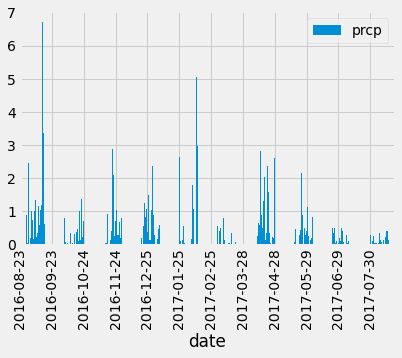

In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

Prev_Last_date = dt.date(Last_date.year-1,Last_date.month,Last_date.day)
Prev_Last_date


# Perform a query to retrieve the data and precipitation scores
ann_prcp = session.query(Measurement.date,func.max(Measurement.prcp)).\
    filter(Measurement.date >= func.strftime("%Y-%m-%d",Prev_Last_date)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()



# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(ann_prcp, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar()
#plt.tight_layout()
plt.xticks(rotation = 90)
plt.locator_params(axis='x',nbins=12)
plt.show()




In [60]:
# Use Pandas to calcualte the summary statistics for the precipitation data

qy_ann_prcp = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= func.strftime("%Y-%m-%d",Prev_Last_date)).\
    order_by(Measurement.date).all()

df_ann_prcp = pd.DataFrame(qy_ann_prcp, columns=['date', 'prcp'])
df_ann_prcp.set_index('date', inplace=True)
df_ann_prcp
ann_prcp_max = df_ann_prcp.groupby(["date"]).max()["prcp"] 
ann_prcp_min = df_ann_prcp.groupby(["date"]).min()["prcp"] 
ann_prcp_sum = df_ann_prcp.groupby(["date"]).sum()["prcp"] 
ann_prcp_count = df_ann_prcp.groupby(["date"]).count()["prcp"] 

dict_ann_prcp = {"Max": ann_prcp_max
                 ,"Min":ann_prcp_min
                 ,"Sum":ann_prcp_sum
                 ,"Count":ann_prcp_count 
                }

df_ann_prcp_summary = pd.DataFrame(dict_ann_prcp)
df_ann_prcp_summary



,Max,Min,Sum,Count
date,,,,
2016-08-23,1.79,0.00,2.71,6
2016-08-24,2.28,0.08,9.33,6
2016-08-25,0.21,0.00,0.54,7
2016-08-26,0.04,0.00,0.10,6
2016-08-27,0.18,0.00,0.32,5
...,...,...,...,...
2017-08-19,0.09,0.00,0.09,3
2017-08-20,0.01,0.00,0.01,2
2017-08-21,0.56,0.00,0.58,3


# Exploratory Station Analysis

In [62]:
# Design a query to calculate the total number stations in the dataset
active_stations = session.query(Station.station).count()
active_stations


9

In [76]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
qry_most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())

all_most_active_stations = qry_most_active_stations.all()
all_most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [81]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = qry_most_active_stations.first()[0]
most_active_station_id

temp_summ = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()

temp_summ

[(54.0, 85.0, 71.66378066378067)]

In [82]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

ann_tobs = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date >= func.strftime("%Y-%m-%d",Prev_Last_date), Measurement.station == most_active_station_id).\
    order_by(Measurement.date).all()

ann_tobs

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

# Close session

In [83]:
# Close Session
session.close()